# Lithology prediction

Firtsly, nesessary imports.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import shutil
import dill
import datetime
import torch

sys.path.insert(0, os.path.join("..", "..", ".."))

from petroflow import WellDataset, WS
from petroflow.batchflow.models.torch import UNet
from petroflow.batchflow import DatasetIndex, FilesIndex, ImagesBatch, Pipeline, V, B, W, L, R, P

# from utils import *

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Define constants that will be used at train and inference stages.

In [3]:
BATCH_SIZE = 4
N_CROPS = 4

DPCM = 20

CROPS_BATCH = BATCH_SIZE * N_CROPS

N_EPOCH = 5000
LENGTH = 10
SHAPE = (3, int(DPCM * LENGTH), DPCM * 10)

FILTERS = ((2 ** np.arange(4)) * 4).tolist()

PATH = '/data/petro_data/data/core_images/core_photo_cm/*'

Remove wells without `core_lithology`

In [4]:
def filter_dataset(ds):
    filter_ppl = (ds.p
                  .init_variable('wells', default=[])
                  .has_attr('core_lithology')
                  .update(V('wells', mode='e'), B().indices)
                  .run(len(ds), n_epochs=1, drop_last=False, shuffle=False))

    filtered_index = ds.index.create_subset(filter_ppl.v('wells'))
    return WellDataset(index=filtered_index)

In [5]:
ds = WellDataset(index=FilesIndex(path=PATH, dirs=True))
ds = filter_dataset(ds)

Get list of classes and construct mapping from classes to labels

In [6]:
def get_classes(ds, batch_size=32):
    classes_ppl = (ds.p
           .init_variable('classes', default=[])
           .update(V('classes', mode='a'), (
               WS('core_lithology')[['FORMATION', 'GRAIN']].apply(concat, axis=1).values.ravel()))
    )

    (classes_ppl.after
        .add_namespace(np)
        .concatenate(L(sum)(V('classes'), []), save_to=V('classes', mode='w'))
        .unique(V('classes'), save_to=V('classes'))
    )

    classes_ppl.run(batch_size, n_epochs=1, drop_last=False)
    return classes_ppl.v('classes')

In [7]:
def concat(df):
    return df.FORMATION + ' ' + df.GRAIN

In [8]:
classes = get_classes(ds, 1)
reverse_mapping = dict(enumerate(classes))
mapping = {value: key for key, value in reverse_mapping.items()}

Preload all the data to make training process faster.

In [9]:
%%time

load_ppl = (ds.p
    .create_segments(src='samples', connected=True)
    .create_segments(src='core_lithology', connected=True)
    .drop_short_segments(LENGTH)
    .load_core(pixels_per_cm=DPCM, core_width=10)
)

batch = load_ppl.next_batch(len(ds), n_epochs=1)

preloaded = ({k: v for k, v in zip(batch.indices, batch.wells)}, )
ds = WellDataset(index=batch.index, preloaded=preloaded, copy=False)
ds.split(shares=0.5, shuffle=42)

CPU times: user 13min 7s, sys: 3min 8s, total: 16min 15s
Wall time: 3min 49s


In [10]:
import matplotlib.pyplot as plt
ds.data.wells['136_новопортовское'].iter_level()[0].core_dl.shape
# plt.imshow(ds.data.wells['136_новопортовское'].iter_level()[0].core_dl[:2000] / 255)

(6100, 200, 3)

In [11]:
ds.data.wells['136_новопортовское'].iter_level()[0].core_dl.shape

(6100, 200, 3)

In [12]:
def get_classes_distribution(*datasets, columns=None, classes=None):
    if columns is None:
        columns = range(len(datasets))
    distribution = []
    for ds, name in zip(datasets, columns):
        ppl = (ds.p
               .init_variable('df', default=[])
               .update(V('df', mode='e'), WS('core_lithology').ravel())
              )

        df = ppl.run(len(ds), n_epochs=1).v('df')

        df = (pd.concat(df)
              .reset_index(drop=False)
              .groupby(['FORMATION', 'GRAIN'])
              .apply(lambda x: (x.DEPTH_TO - x.DEPTH_FROM).sum()))

        df_index = df.index.to_frame().apply(concat, axis=1)
        stat = pd.concat([df_index, df], axis=1, sort=True)
        stat.columns = ['CLASS', name]
        stat = stat.set_index('CLASS')
        if classes is not None:
            for item in set(classes) - set(stat.index):
                stat.loc[item] = 0
        distribution.append(stat)
    df = pd.concat(distribution, axis=1, sort=True).fillna(0)
    for name in columns:
        df[name+'_ratio'] = df[name] / df[name].sum()
    return df

In [13]:
distribution = get_classes_distribution(ds.train, ds.test, columns=['TRAIN', 'TEST'], classes=classes)
weights = distribution['TRAIN'].values
weights = (1 / weights)
weights[weights == np.inf] = weights[weights != np.inf].max()
weights = weights / sum(weights) * len(weights)

## Train model

In [14]:
crop_template = (Pipeline()
       .add_namespace(np)
       .copy()
       .random_crop(length=LENGTH, n_crops=N_CROPS)
       .update(WS('core_lithology')['CLASS'],
               WS('core_lithology')[['FORMATION', 'GRAIN']].apply(concat, axis=1).ravel())
       .create_mask(src='core_lithology', column='CLASS', mapping=mapping, mode='core')
       .update(B('core'), WS('core_dl').ravel())
       .update(B('masks'), WS('mask').ravel())
       .array(B('core'), save_to=B('core'))
       .array(B('masks'), save_to=B('masks'))
       .reshape(B('masks'), (-1, 1, SHAPE[1]), save_to=B('masks'))
)

In [15]:
augmentation_template = (
    Pipeline()
    .update(B().index, L(DatasetIndex)(L(len)(B('core'))))
    .rebatch(CROPS_BATCH, batch_class=ImagesBatch, components=('core', 'masks'))
    .add_namespace(np)
    .to_pil(src='core', dst='core')
    .scale(src='core', dst='core', preserve_shape=True, factor=P(R('uniform', low=1, high=1.5)))
    .cutout(shape=P(R('randint', low=0, high=DPCM * 10)),
            origin=P(R('uniform', size=2)), color=0,
            src='core', dst='core', p=0.5)
    .multiply(src='core', dst='core', multiplier=P(R('uniform', low=0.7, high=1.2)))
    .to_array(src='core', dst='core', dtype='float32')
    .transpose(B('core'), axes=(0, 3, 1, 2), save_to=B('core'))
)

In [16]:
model_config = {
    "body/encoder/num_stages": len(FILTERS[:-1]),
    'body/encoder/blocks/filters': FILTERS[:-1],
    "body/decoder/blocks/filters": FILTERS[-2::-1],
    "initial_block/inputs": "inputs",
    "inputs/inputs/shape": SHAPE,
    'inputs/masks/shape': (len(mapping), 1, SHAPE[1]),
    "head": dict(layout="c",
                 kernel_size=(SHAPE[2], 1), padding='valid', conv=dict(bias=True)),
    "loss": 'ce',# dict(weight=torch.tensor(weights, dtype=torch.float32).to('cuda:0'))),
    "optimizer": {"name": "Adam", "lr": 0.01},
    "output": 'proba',
    "device": 'cuda:0'
}
        
train_template = (Pipeline()
    .init_variable('loss_history', default=[])
    .init_model('dynamic', UNet, 'model', model_config)
    .train_model('model', B('core').astype('float32'), B('masks'),
                 fetches='loss', save_to=V('loss_history', mode='a'))
)

train_ppl = (crop_template + augmentation_template + train_template) << ds.train

In [17]:
train_ppl.next_batch(BATCH_SIZE, n_epochs=None, bar=True, bar_desc=W(V('loss_history')[-1]))

  0%|          | 0/9223372036854775807 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

../../../petroflow/batchflow/batchflow/batch_image.py:962: UserWarning:

Note that some info might be lost during `multiply` transformation since PIL.image stores data as `np.uint8`. To suppress this warning, use `preserve_type=True` or consider using `to_array` action before multiplication.

2.9685187:   0%|          | 1/9223372036854775807 [00:15<40798028882168454:15:28, 15.92s/it]

Dump results

In [18]:
def dump_results(train_ppl, path):
    if not os.path.exists(path):
        os.makedirs(path)

    train_ppl.get_model_by_name('model').save(os.path.join(path, 'unet.torch'))

    with open(os.path.join(path, 'loss.pkl'), 'wb') as f:
        dill.dump(train_ppl.v('loss_history'), f)

def dump_metrics(test_ppl, path):
    metrics = test_ppl.v('metrics')
    with open(path, 'wb') as f:
        dill.dump(test_ppl.v('metrics'), f)
        
def get_last_model_path(path, index=-1):
    return sorted(glob.glob(path))[index]

In [19]:
SAVE_TO = './models/unet_' + str(datetime.datetime.now()).replace(' ', '_')
dump_results(train_ppl, SAVE_TO)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning:

Couldn't retrieve source code for container of type DefaultBlock. It won't be checked for correctness upon loading.

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning:

Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning:

Couldn't retrieve source code for container of type EncoderModule. It won't be checked for correctness upon loading.

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning:

Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning:

Couldn't retrieve source code for container of type BaseConvBlock. It won't be checked for correctness upon loading.

/usr/local/li

In [20]:
model_path = get_last_model_path('./models/unet_*')
print(model_path)

./models/unet_2020-04-06_06:34:02.164908


Load loss

In [21]:
with open(os.path.join(model_path, 'loss.pkl'), 'rb') as f:
    loss = dill.load(f)

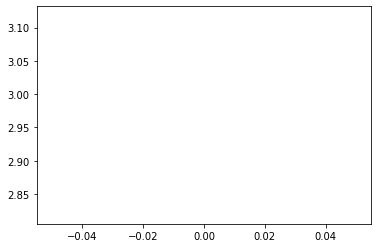

In [22]:
import pandas as pd
plt.plot(loss)
plt.plot(pd.Series(loss).rolling(window=100).mean())

## Inference

In [23]:
def test_template(length, random_crop=False, step=None, n_crops=None):
    step = step or length
    n_crops = n_crops or 4

    if random_crop:
        ppl = Pipeline().copy().random_crop(length=length, n_crops=n_crops)
    else:
        ppl = Pipeline().copy().crop(length=length, step=step)

    ppl = ppl + (Pipeline()
        .add_namespace(np)
        .add_components(('core', 'masks'))
        .update(WS('core_lithology')['CLASS'], WS('core_lithology')[['FORMATION', 'GRAIN']].apply(concat, axis=1).ravel())
        .create_mask(src='core_lithology', column='CLASS', mapping=mapping, mode='core').update(B('core'), WS('core_dl').ravel())
        .update(B('masks'), WS('mask').ravel())
        .array(B('core'), save_to=B('core'))
        .array(B('masks'), save_to=B('masks'))
        .transpose(B('core'), axes=(0, 3, 1, 2), save_to=B('core'))
        .reshape(B('masks'), (-1, 1, DPCM * 10), save_to=B('masks'))
        .update(B().index, L(DatasetIndex)(B('core').shape[0]))
        .rebatch(32, components=('core', 'masks'), batch_class=ImagesBatch)
        .init_variable('metrics')
        .add_namespace(np)
        .init_model('dynamic', UNet, 'model', config={
                        'device': 'gpu:0', 'load/path': os.path.join(model_path, 'unet.torch')
                    })
        .predict_model('model', B('core').astype('float32'), fetches='proba', save_to=B('proba'))
        .gather_metrics('classification', targets=B('masks').reshape(-1),
                        predictions=B('proba').argmax(1).reshape(-1),
                        fmt='labels', num_classes=len(mapping), save_to=V('metrics', mode='u'))
    )
    return ppl

test_ppl = test_template(LENGTH, random_crop=False) << ds.test

In [24]:
# ds.data.wells['250_test'].tree_depth

In [25]:
test_ppl.next_batch(1, bar=True)

dump_metrics(test_ppl, os.path.join(model_path, 'metrics.pkl'))


  0%|          | 1/9223372036854775807 [00:02<6781301491646973:43:28,  2.65s/it]

In [26]:
def get_last_model_path(path, index=-1):
    return sorted(glob.glob(path))[index]

model_path = get_last_model_path('./models/unet_*', -1)

In [27]:
with open(os.path.join(model_path, 'metrics.pkl'), 'rb') as f:
    metrics = dill.load(f)

F1-scores

In [28]:
for i, item in enumerate(metrics.evaluate('f1_score', agg='mean', multiclass=None)):
    print(reverse_mapping[i], item)

алевролит UNKNOWN 0.0
алевролит крупно-мелкозернистый 0.0
алевролит крупнозернистый 0.0
алевролит мелкозернистый 0.0
алевролит разнозернистый 1.0
аргиллит UNKNOWN 0.0
глина UNKNOWN 0.0
доломит UNKNOWN 1.0
известняк UNKNOWN 0.0
песчаник UNKNOWN 0.0
песчаник крупнозернистый 0.0
песчаник мелкозернистый 0.00710732054015636
песчаник разнозернистый 1.0
песчаник средне-мелкозернистый 1.0
песчаник среднезернистый 1.0
песчаник тонко-мелкозернистый 0.0
песчаник тонкозернистый 0.0
уголь UNKNOWN 0.0


Some examples

In [34]:
from matplotlib import colors

def plot_examples(batch, reverse_mapping, n_crops=10, random=True):
    images = np.transpose(batch.core, axes=(0, 2, 3, 1))
    predictions = np.tile(batch.proba.argmax(1), (1, 200, 1)).transpose(0, 2, 1)
    targets = np.tile(batch.masks, (1, 200, 1)).transpose(0, 2, 1)

    cmap = colors.ListedColormap(
        ['green'] * 4 + ['blue', 'grey', 'yellow'] + ['orange'] * 6
    )

    bounds = np.arange(-0.5, len(reverse_mapping) + 0.5, 1)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    a = np.ones((20, 200))
    b = np.concatenate([i * a for i in range(len(reverse_mapping))], axis=0)
    plt.figure(figsize=(15, 10))
    plt.imshow(b, norm=norm, cmap=cmap)

    for i, value in reverse_mapping.items():
        plt.text(20, 20 * i + 11, value, color='black', fontsize=12, bbox=dict(facecolor='white'))
    plt.show()
    
    items = np.random.choice(len(images), n_crops, replace=False) if random else range(n_crops)
    for i in items:
        plt.figure(figsize=(15, 15))
        plt.subplot(131)
        plt.imshow(images[i] / 255)
        plt.subplot(132)
        plt.imshow(predictions[i], vmin=0, vmax=len(reverse_mapping), norm=norm, cmap=cmap)
        plt.subplot(133)
        plt.imshow(targets[i], vmin=0, vmax=len(reverse_mapping), norm=norm, cmap=cmap)
        plt.show()

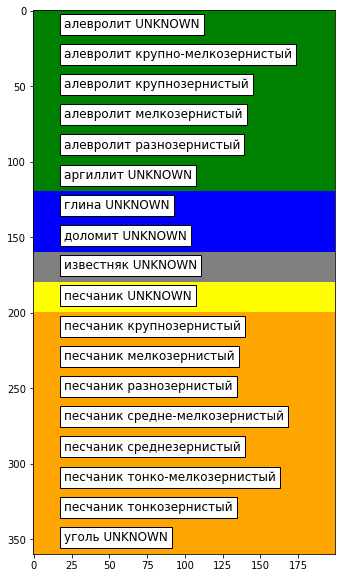

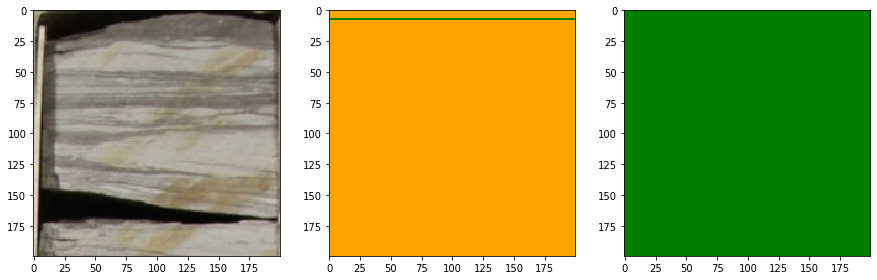

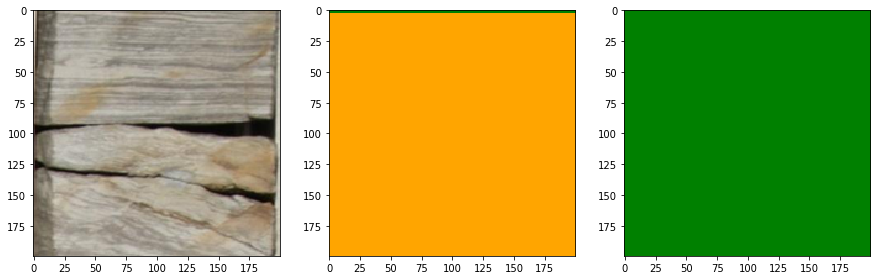

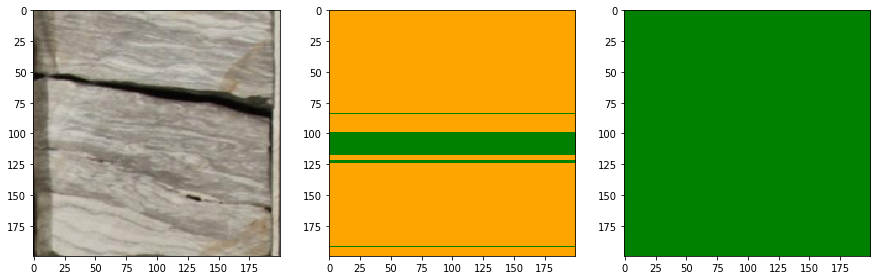

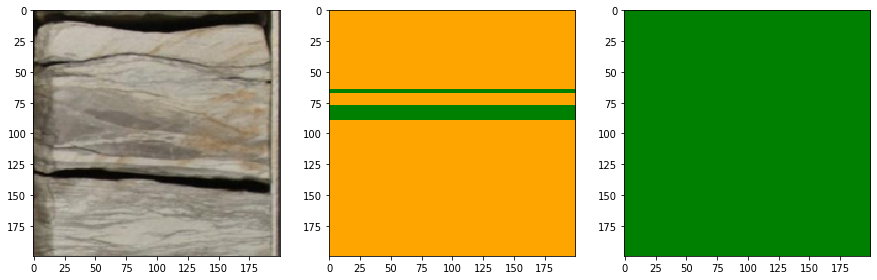

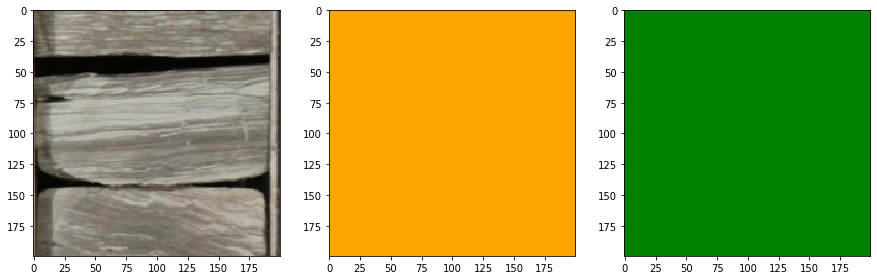

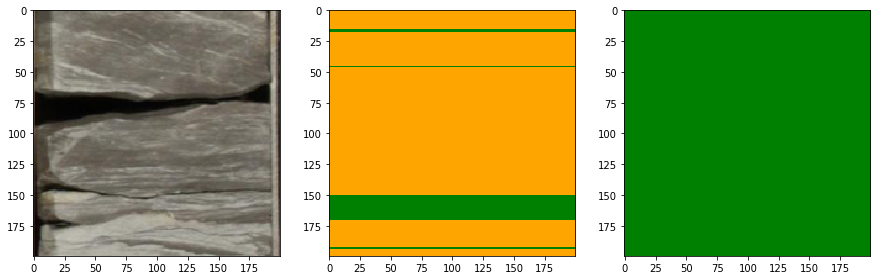

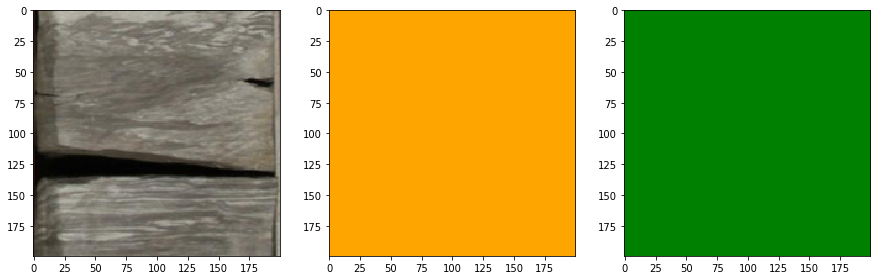

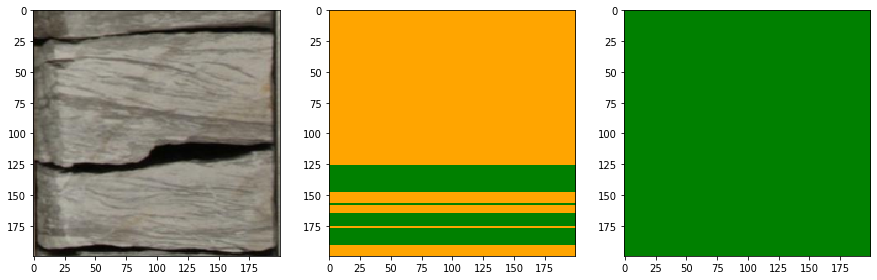

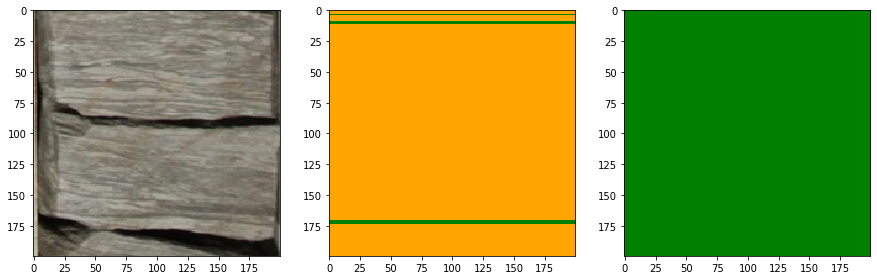

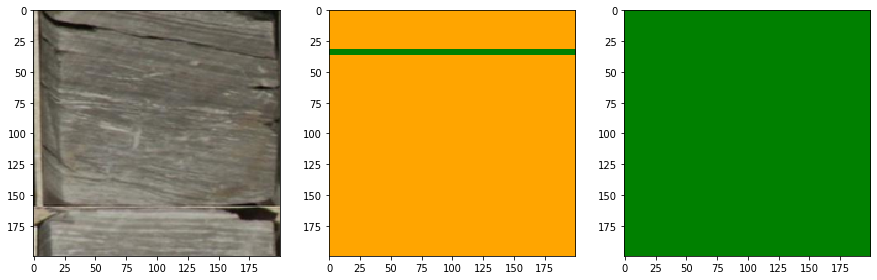

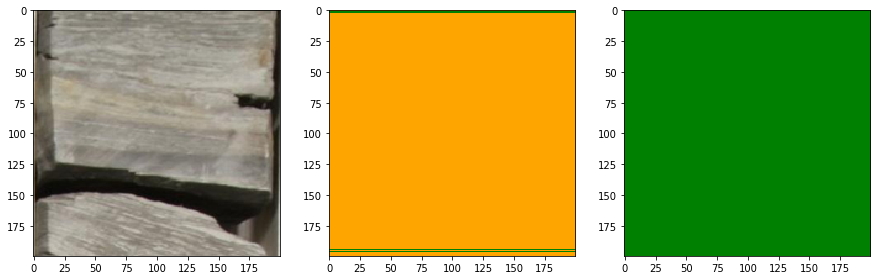

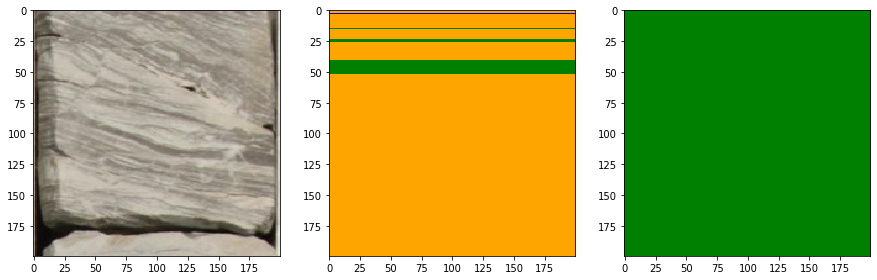

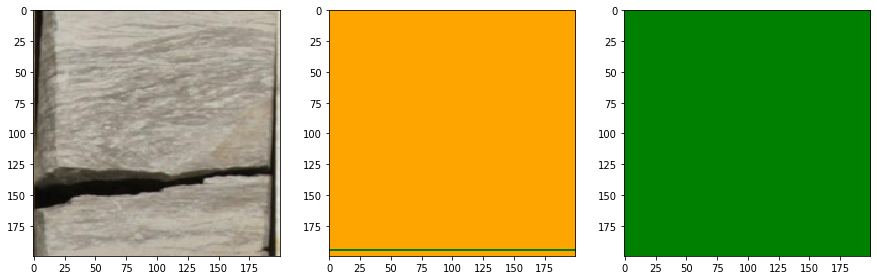

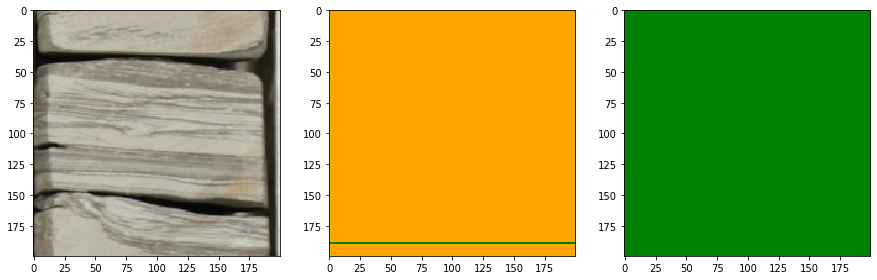

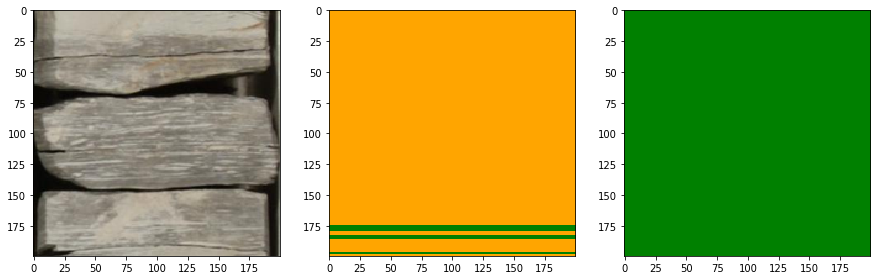

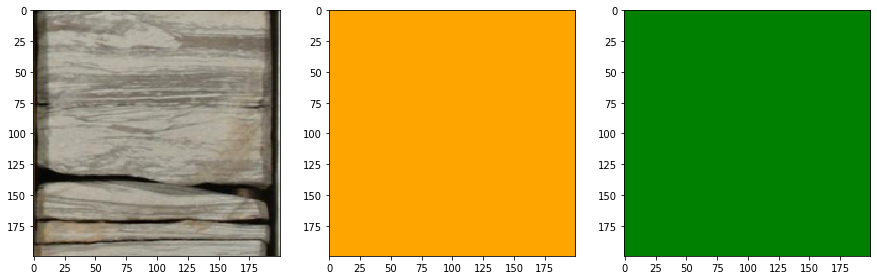

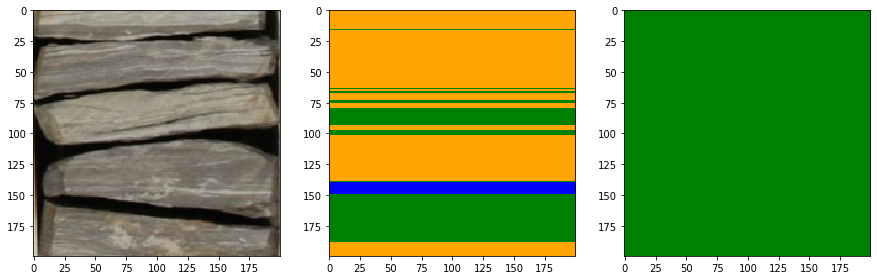

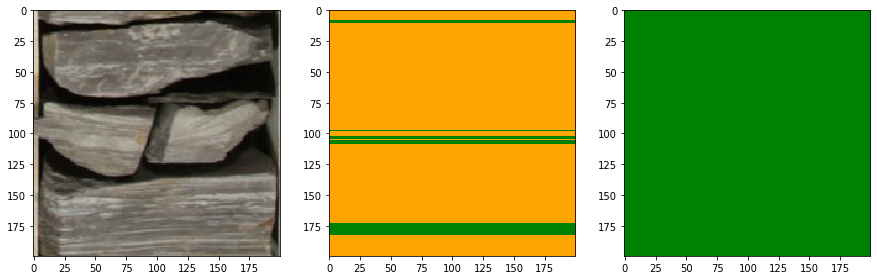

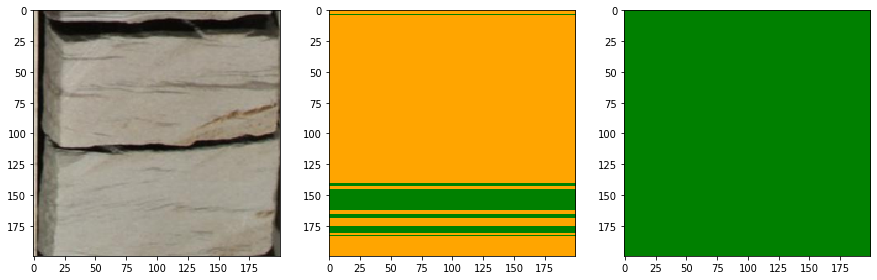

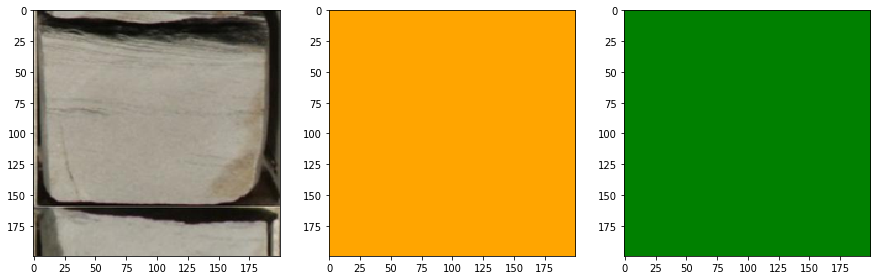

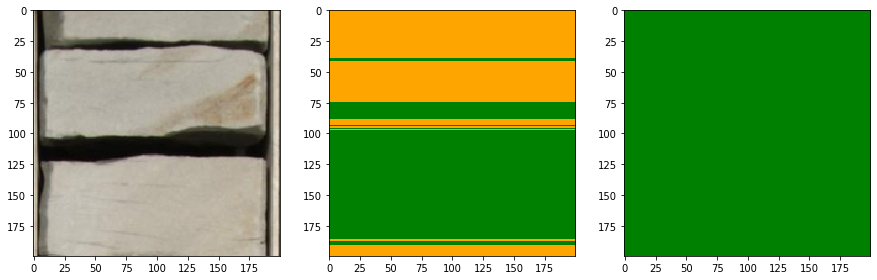

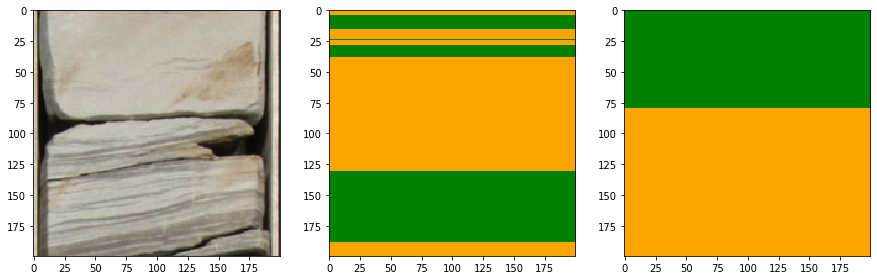

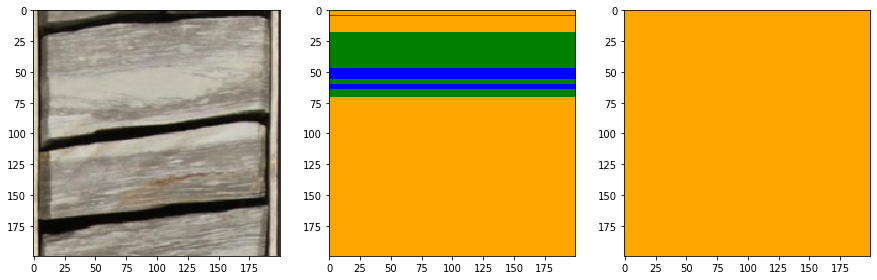

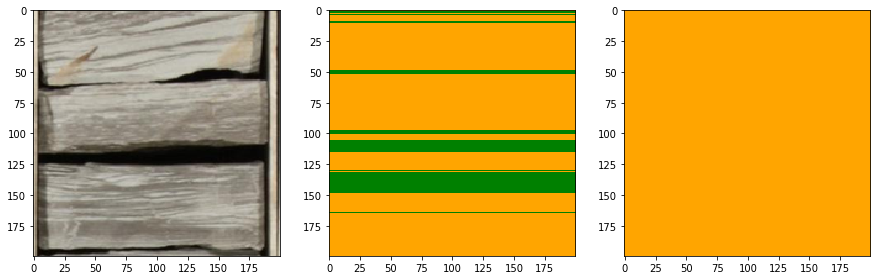

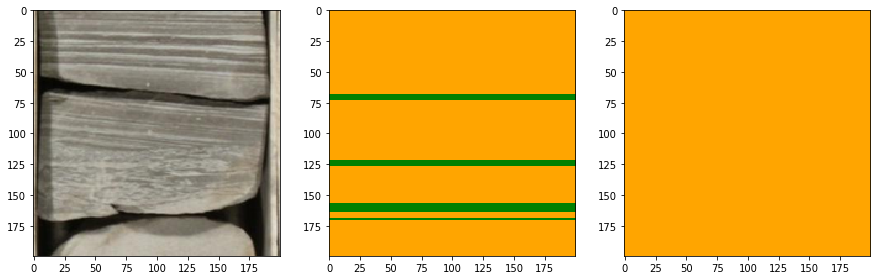

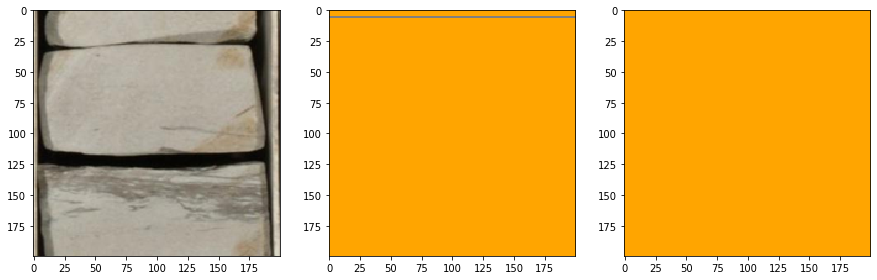

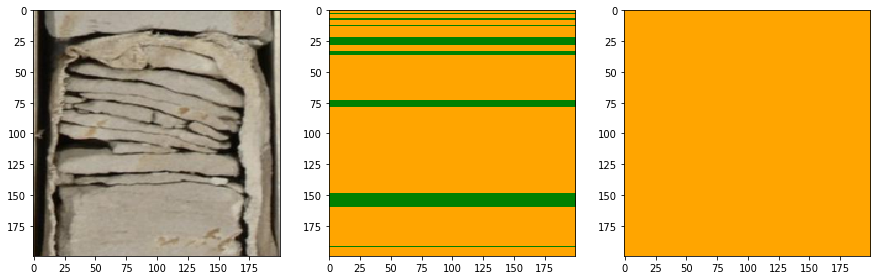

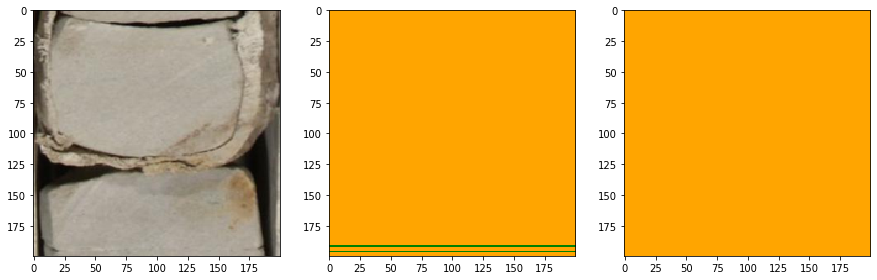

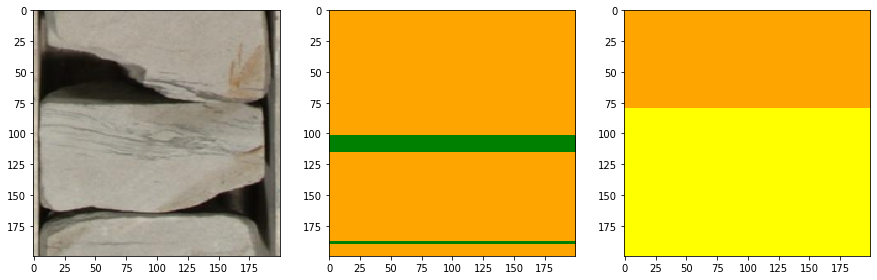

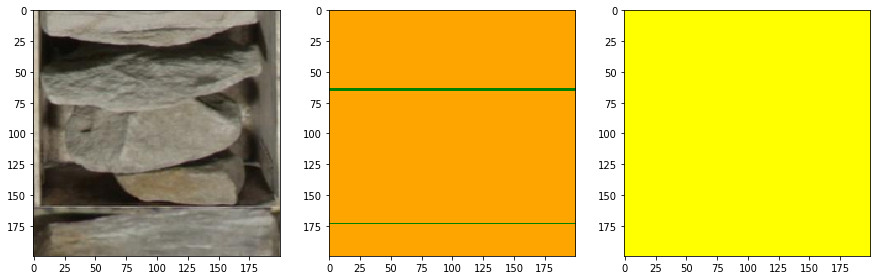

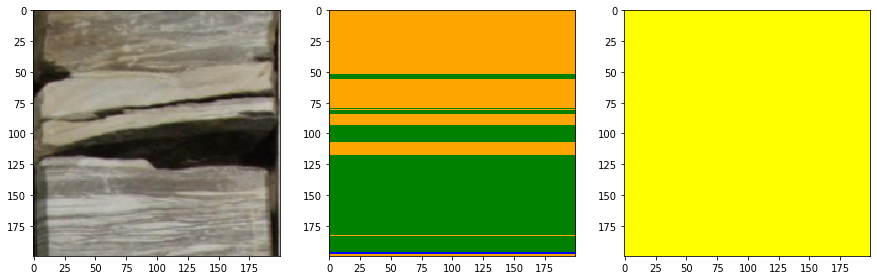

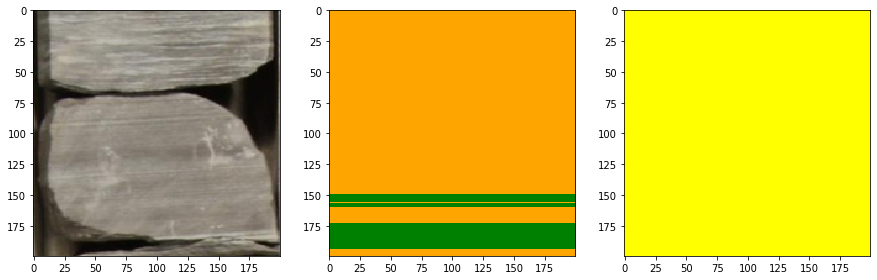

In [35]:
plot_ppl = (test_template(LENGTH, random_crop=False) << ds.test)

batch = plot_ppl.next_batch(1)
plot_examples(batch, reverse_mapping, 32, random=False)

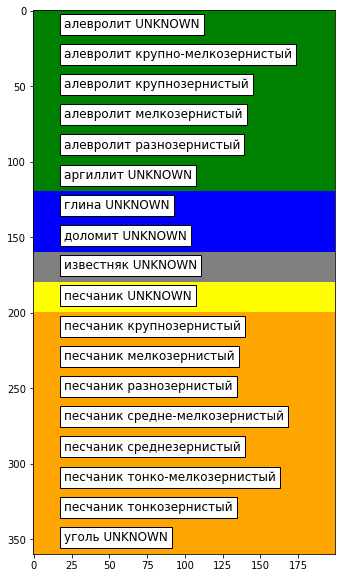

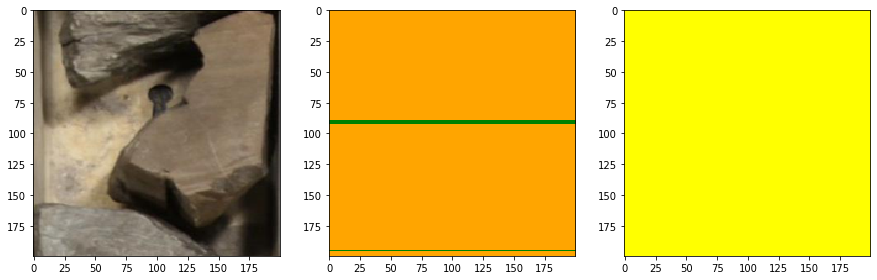

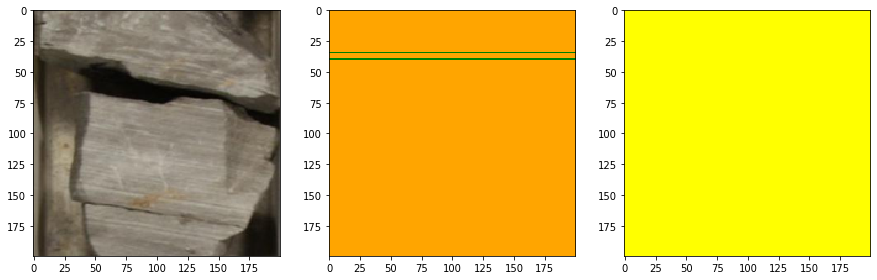

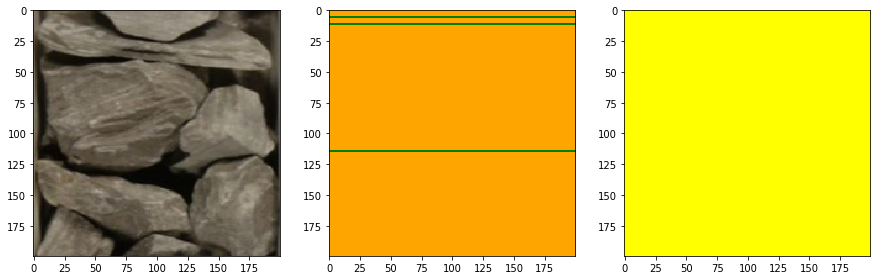

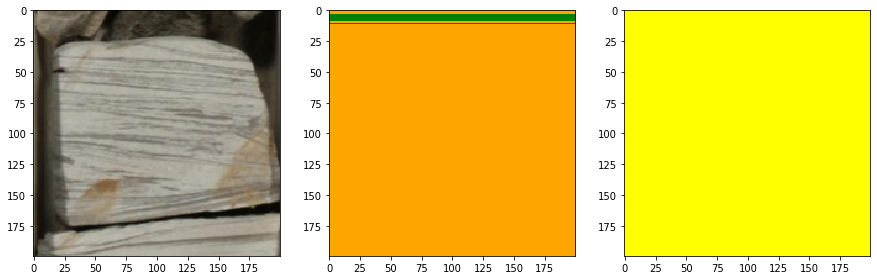

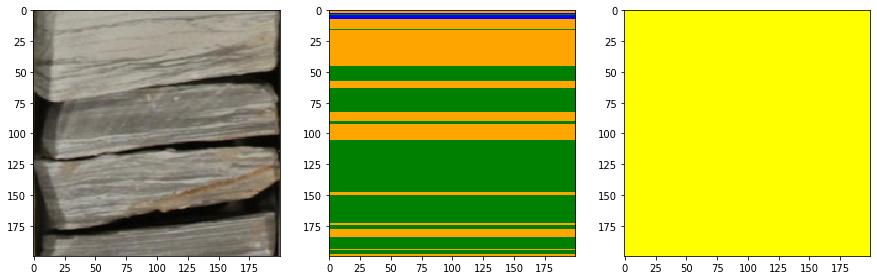

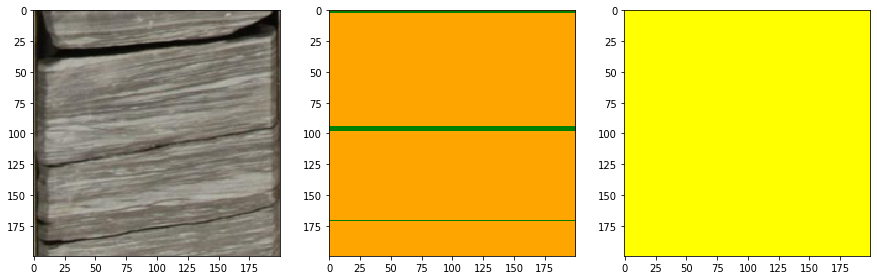

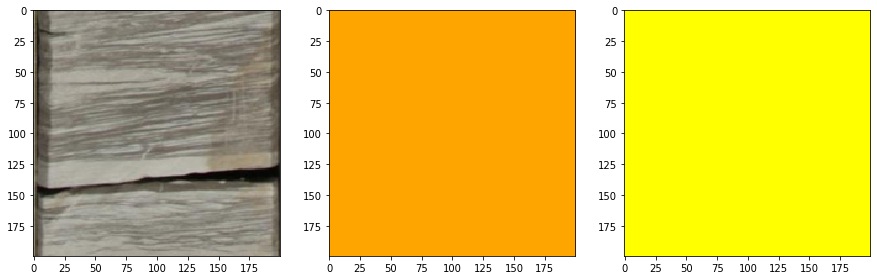

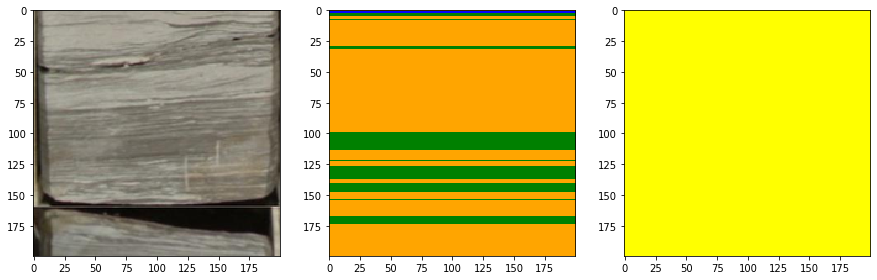

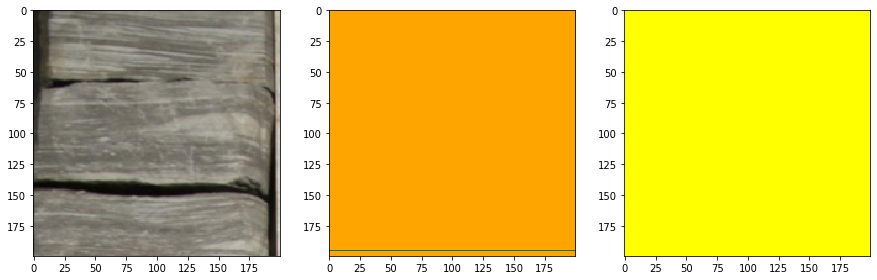

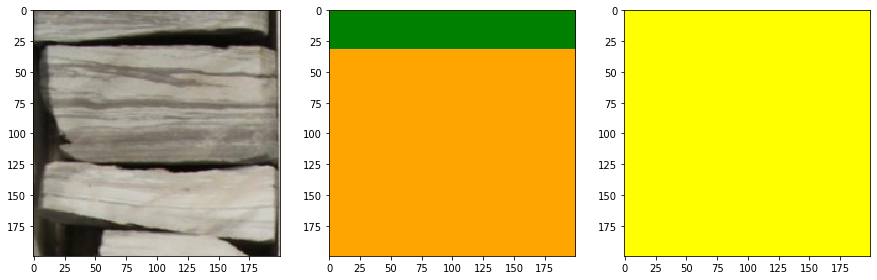

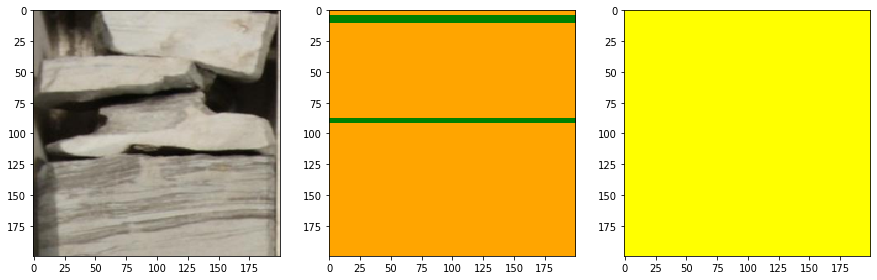

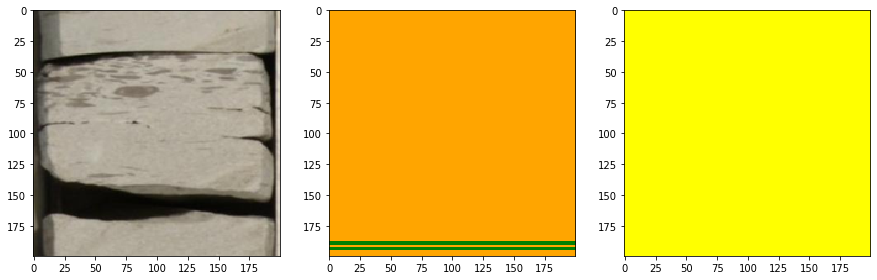

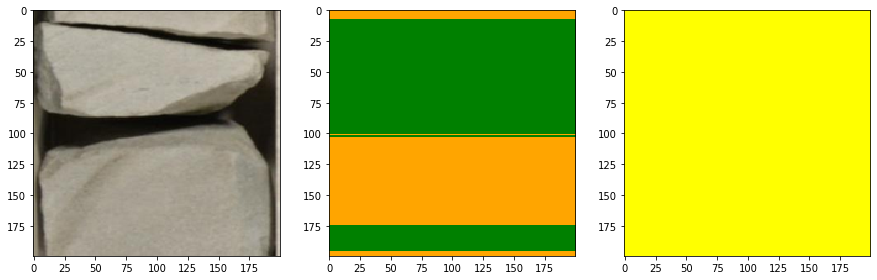

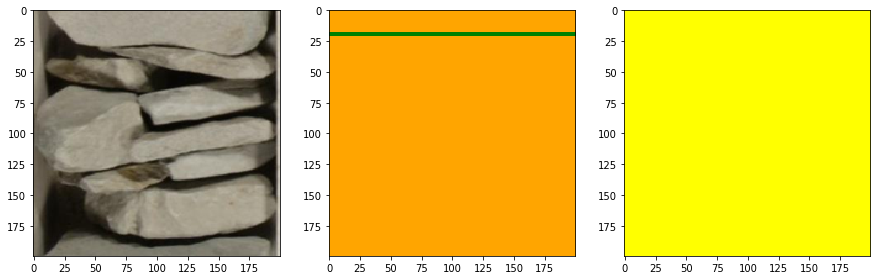

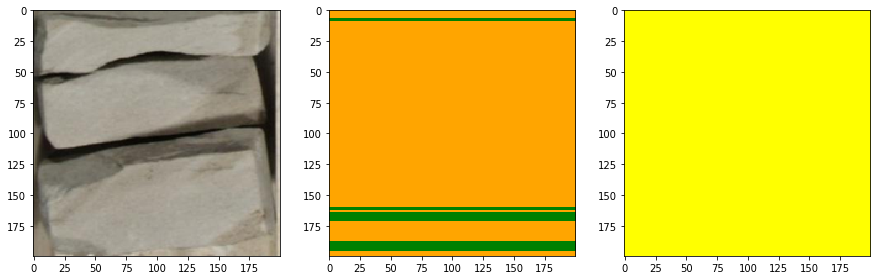

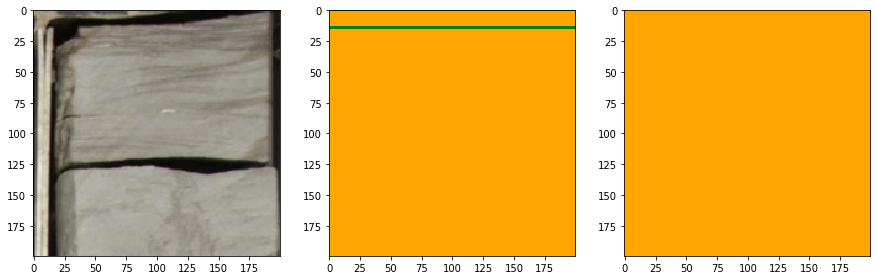

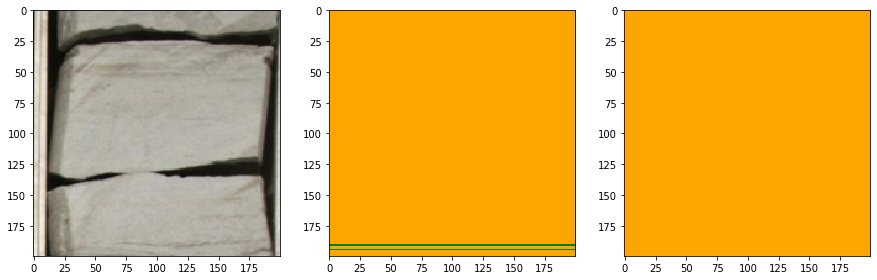

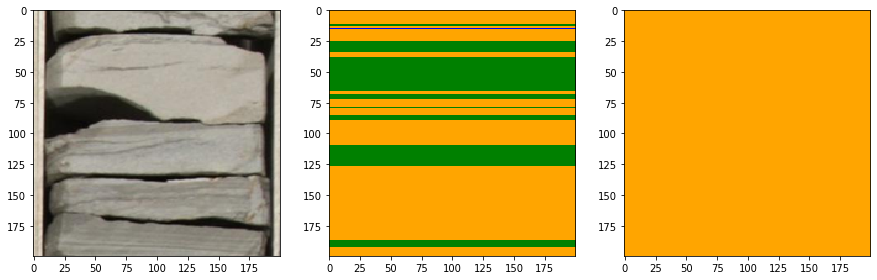

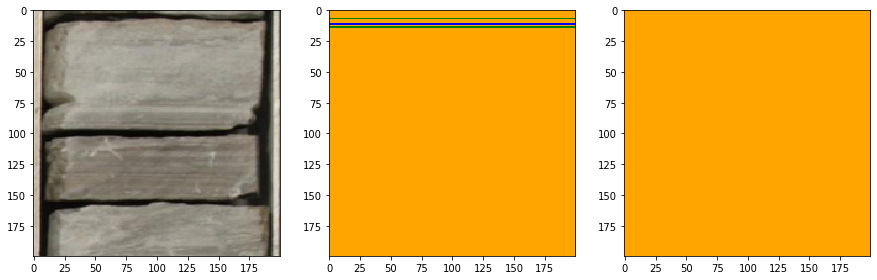

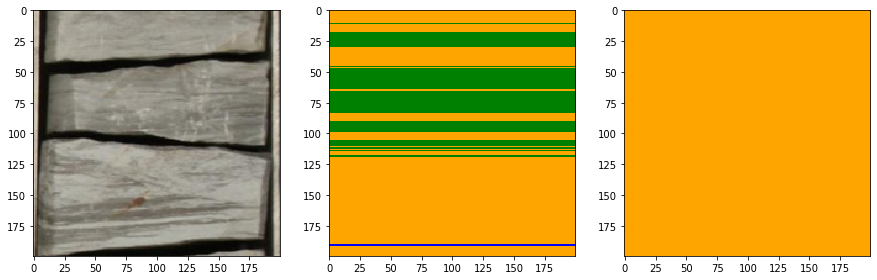

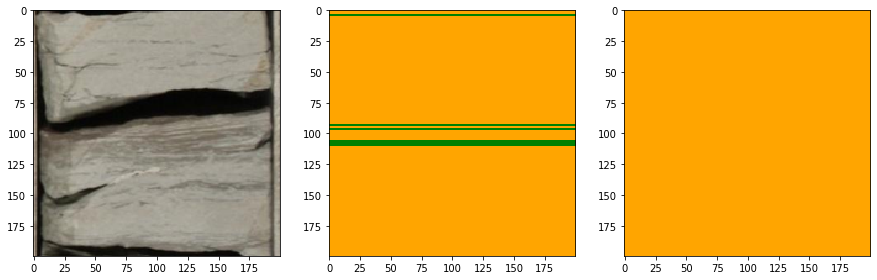

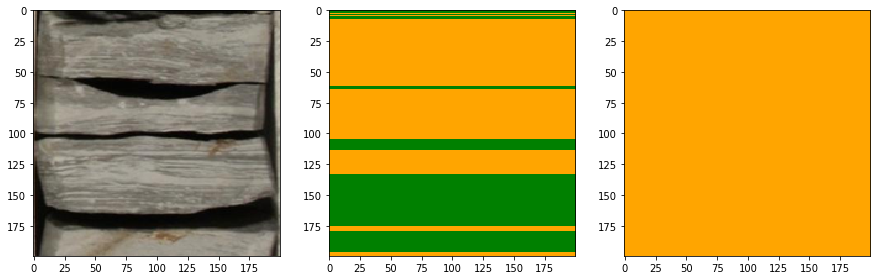

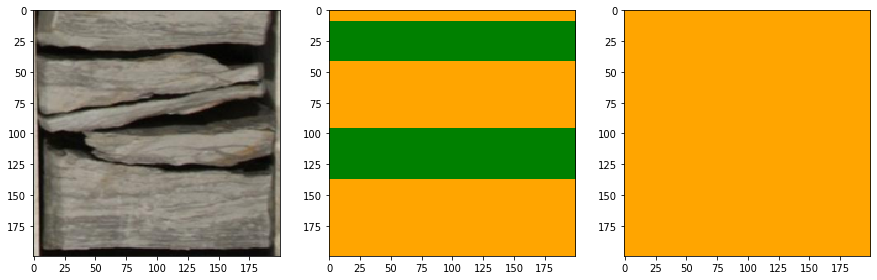

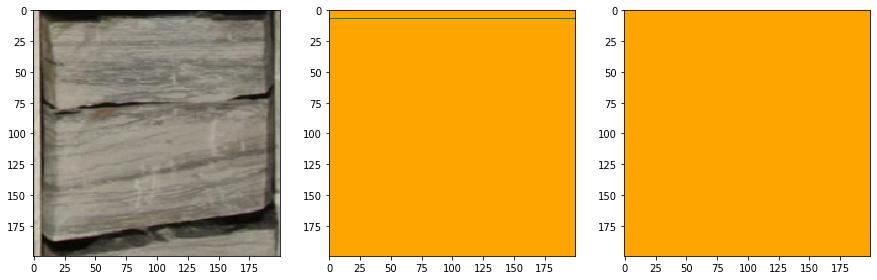

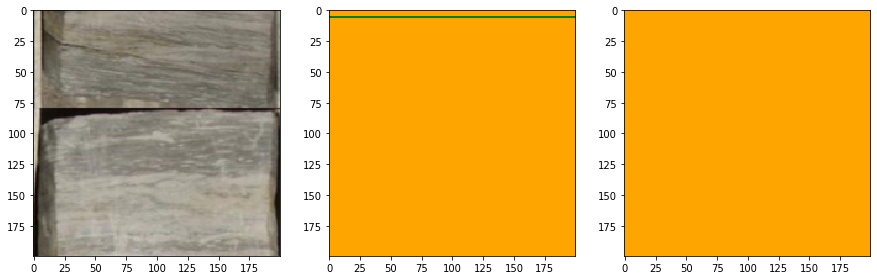

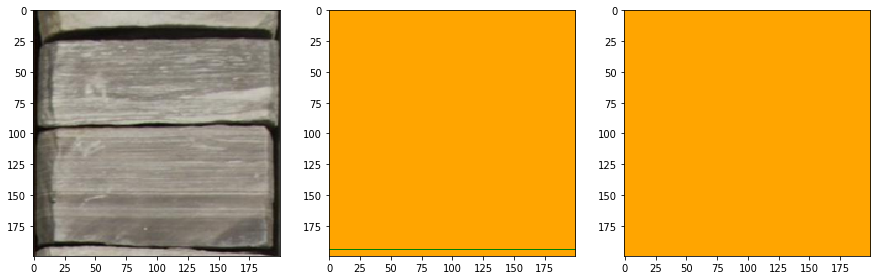

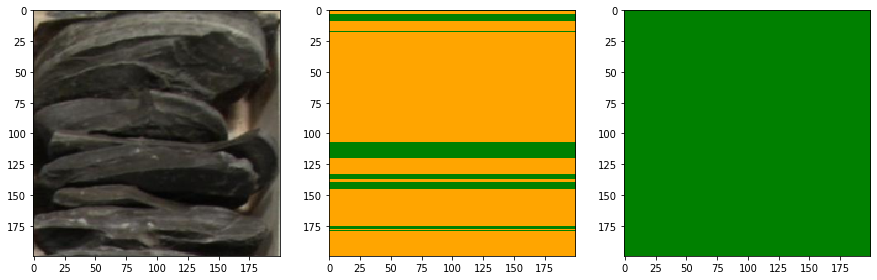

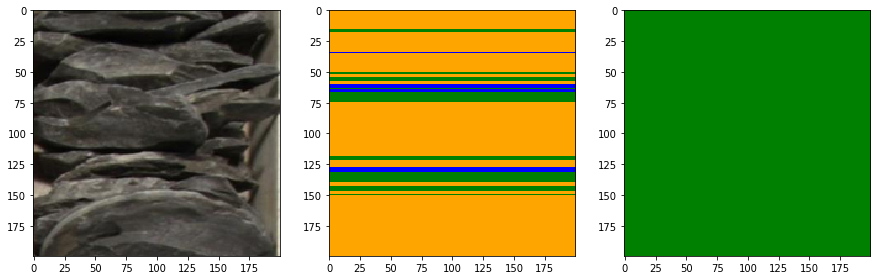

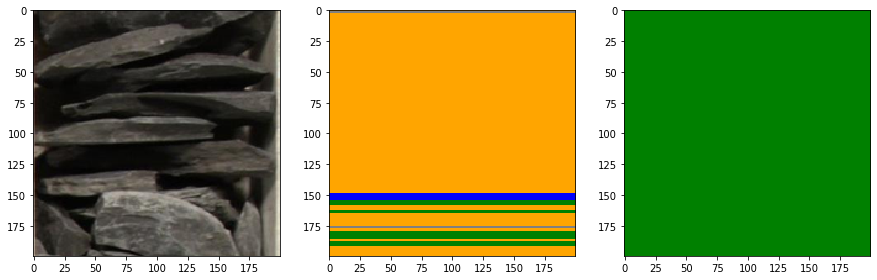

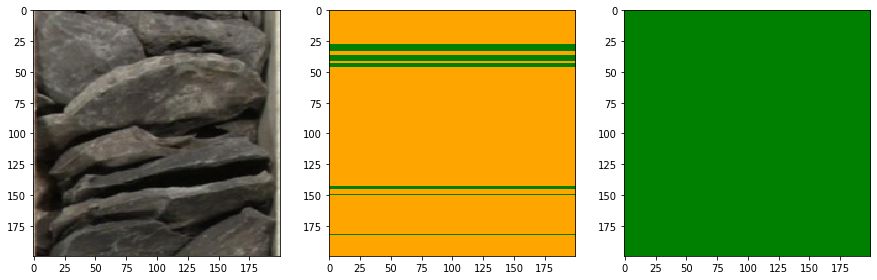

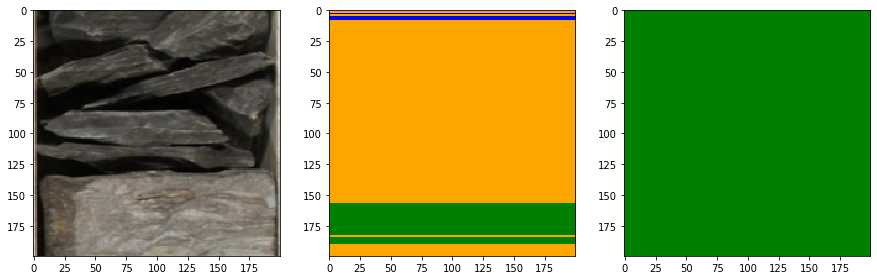

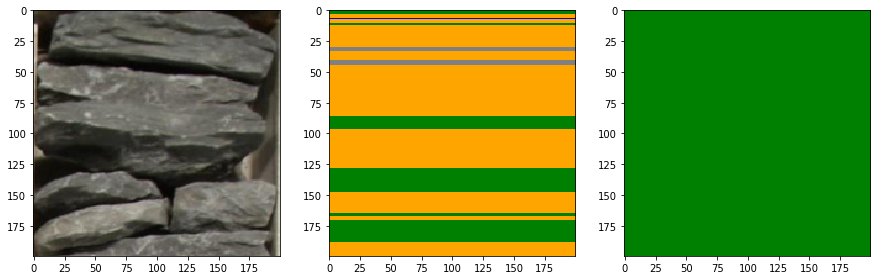

In [36]:
batch = plot_ppl.next_batch(1)
plot_examples(batch, reverse_mapping, 32, random=False)